## EE 769 Group Project
**Group Members:**
1. Kushagra Mishra (200010042)
2. Advait Mehla (200010004)
3. Advait Risbud (200110089)

**Project title:** Image Super-resolution using SRCNN. 

**Abstract:** A deep convolutional neural network architecture is used to super-resolve images. This technique used neural networks to learn the difference between images of high and poor resolution, the network can then be applied on new images of a poor quality to super-resolve them. The primary metrics used for gauging image quality are the peak signal-to-noise ratio (reference to PSNR paper), mean-squared error, and structural similarity index (ref to skimage documentation). 

In [1]:
# Import libraries required
import sys
import tensorflow 
import cv2
import numpy as np
import matplotlib
import skimage
import math
import os
import PIL
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers.legacy import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt

**Function Name:** `mse(target, ref)`
<br>**Function Arguments:** Target Image (`target`), Reference Image(`ref`)
<br>**Function Outputs:** MSE (`err`)


The below block defined the function to calculate the Mean Square Error (MSE) between two given images. For two $m\times n$ monochrome image, MSE is mathematically defined as 
$$MSE:=\frac{1}{nm}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}[T(i,j)-R(i,j)]^2$$

In [2]:
def ret_mse(target, ref):
  
    err_out = np.sum((target- ref) ** 2)
    err_out /= float(target.shape[0] * target.shape[1])
    
    return err_out

**Function Name:** `psnr(target,ref)`
<br>**Function Arguments:** Target Image (`target`); Reference Image (`ref`)
<br>**Function Outputs:** PSNR in dB (`psnr`) 


We will use the the Peak-Signal-to-Noise-Ratio (PSNR) as a metric of the performance of our model.


> Peak-Signal-to-Noise-Ratio is defined as the ratio between the maximum possible power of the useful part of the signal and the corrupting noise present in the signal. Mathematically,
$$PSNR\,(\text{in dB}):= 10\log_{10}\begin{pmatrix}\frac{MAX_I^2}{MSE}\end{pmatrix}$$.

In the case of an image signal, the maximum possible value of the useful part of the signal is equivalent to maximum possible intensity of a particular pixel and is, thus, equal to 255. Plugging this into our expression for PSNR, we get
$$PSNR\,(\text{in dB}) = 20\log_{20}\begin{pmatrix}\frac{255}{\sqrt{MSE}}\end{pmatrix}$$



In [3]:
def ret_psnr(target, ref):
         
    target_data = target
    ref_data = ref
    mse = ret_mse(target, ref)

    psnr_out = 20 * math.log10(255) - 10*math.log10(mse)

    return psnr_out

**Function Name:** `compare_images(target, ref)`
<br>**Function Arguments:** Target Image (`target`), Reference Image (`ref`)
<br>**Function Output:** Score Array (`score`)

The below function returns an array consisting of performance scores (PSNR, MSE, SSIM) for a given target image and a reference image. 

In [4]:
def compare_images(target, ref):
    scores = []
    scores.append(ret_psnr(target, ref))
    scores.append(ret_mse(target, ref))
    scores.append(ssim(target, ref, channel_axis=2))
    
    return scores

**Function Name:** `ret_image_set(target, ref)`
<br>**Function Arguments:** Image Set Path (`path`), Resize (`resize`), Shape for resizing (`shape`)
<br>**Function Output:** Image Set (`image_set`)

The function defined below is used to return an array of all images present in the specified folder. Additionally, if the bool `resize` is true, then all the images in the folder are first resized to the shape specified in `shape`.

In [5]:
def ret_image_set(path, resize, shape = (0, 0)):
  image_set = []
  for i in range(100):
      img = cv2.imread(path + '/' + str(i) + '.png');
      
      if resize == True:
        img = cv2.resize(img, shape, interpolation = cv2.INTER_LINEAR)
      image_set.append(img);
  return image_set 

Now, load our dataset. 

Ref: https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution

In [62]:
!unzip archive.zip;
dataset_hr = ret_image_set('/content/Data/HR', False)
shape_hr_h, shape_hr_w, _ = dataset_hr[0].shape
dataset_lr = ret_image_set('/content/Data/LR', True, (shape_hr_w, shape_hr_h))

**Function Name:** `modcrop(img, scale)`
<br>**Function Arguments:** Image (`img`), Scale (`scale`)
<br>**Function Output:** Cropped Image (`img_out`)

The function below is used to crop the image down so that its dimensions are each divisible by `scale`. This is done to prevent shape mismatches when the image is passed into the CNN.

In [64]:
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img_out = img[0:sz[0], 1:sz[1]]
    return img_out

**Function Name:** `shave(img, border)`
<br>**Function Arguments:** Image (`img`), Border (`border`)
<br>**Function Output:** Cropped Image (`img_out`)

The function below is used to shave the border off the image by the amount specified in `border`. This is done to align the dimensions of the input and the output of the CNN.

In [63]:
def shave(img, border):
    img_out = img[border: -border, border: -border]
    return img_out

**Function Name:** `preprocess_image(img)`
<br>**Function Arguments:** Image (`img`)
<br>**Function Output:** Preprocessed Image (`Y_out`)

The function below preprocesses the training and validation images so that they are compatible with the model training function. The output of the function is the normalized Y component of the input image.


In [25]:
def preprocess_image(img):

    img = modcrop(img, 3)
    temp = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y_out = np.zeros((temp.shape[0], temp.shape[1], 1), dtype=float)
    Y_out[:, :, 0] = temp[:, :, 0].astype(float) / 255
    return Y_out

We now perform preprocessing on the data using the functions defined above, and make a test-validation split. 

We have considered a 85-15 split between training and validation data. 

In [26]:
#Arrays to hold input and target images
dataset_hr_proc = []            
dataset_lr_proc = []

#Preprocess the images
for img in dataset_lr:
  dataset_lr_proc.append(preprocess_image(img));

for img in dataset_hr:
  dataset_hr_proc.append(shave(preprocess_image(img), 6));

dataset_lr_proc = np.array(dataset_lr_proc)
dataset_hr_proc = np.array(dataset_hr_proc)

#Make the training validation split
[train_lr, val_lr, train_hr, val_hr] = train_test_split(dataset_lr_proc, dataset_hr_proc, test_size=0.15, shuffle=True);

**Function Name:** `model()`
<br>**Function Arguments:** Na
<br>**Function Output:** SRCNN model

The function below is used to define the SRCNN model which we will be using to perform image super resolution. The model summary can be found when we call the function. The neural network consists of 3 hidden Convolutional + ReLU layers, 1 input channel, and 1 output channel.

In [27]:
def model():
    
    # define model type
    SRCNN_out = Sequential()
  
    # add model layers
    SRCNN_out.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN_out.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN_out.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))


    # define optimizer
    adam = Adam(learning_rate=0.0003)
    
    # compile model
    SRCNN_out.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    SRCNN_out.summary()
    
    return SRCNN_out

We now train the first model according to the training and validation data.


In [49]:
SRCNN_1 = model();
train_details = SRCNN_1.fit(train_lr, train_hr, epochs=20, validation_data=(val_lr, val_hr))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, None, None, 128)   10496     
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3/3 [==============================] - 3s 729ms/step - loss: 0.2000 - mean_squared_error: 0.2000 - val_loss: 0.0671 - val_mean_squared_error: 0.0671
Epoch 2/20
3/3 [==============================] - 2s 653ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0078 - val_mean_squared_error: 0

We also load a separate SRCNN with pre-trained weights.

Ref: https://github.com/MarkPrecursor/SRCNN-keras

In [54]:
SRCNN_2 = model();
SRCNN_2.load_weights('3051crop_weight_200.h5')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, None, None, 128)   10496     
                                                                 
 conv2d_31 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 conv2d_32 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


**Function Name:** `ret_deg_ref(img)`
<br>**Function Arguments:** Image Path (`image_path`)
<br>**Function Output:** Input Image (`degraded`), High Resolution Reference Image (`ref`)


The function below is used to get a LR-HR image pair from a specified path. The output images have dimensions aligned with multiples of 3.

In [33]:
def ret_deg_ref(image_path):

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('/content/Data/HR/{}'.format(file))   
    h, w, _ = ref.shape
    degraded = img = cv2.resize(degraded, (w, h), interpolation = cv2.INTER_LINEAR)

    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    return degraded, ref

**Function Name:** `predict(img, srcnn)`
<br>**Function Arguments:** Image (`img`), SRCNN Model (`srcnn`)
<br>**Function Output:** Input Image (`degraded`), High Resolution Reference Image (`ref`)

The function below returns the predicted super resolution image given by the model `srcnn`.

In [35]:
def predict(img, srcnn):
    temp = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    pred = srcnn.predict(Y, batch_size=1)
    pred *= 255
    pred[pred[:] > 255] = 255
    pred[pred[:] < 0] = 0
    pred = pred.astype(np.uint8)
    temp = shave(temp, 6)
    temp[:, :, 0] = pred[0, :, :, 0]
    pred_out = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    return pred_out

**Function Name:** `ret_scores(image_path, srcnn_1, srcnn_2)`
<br>**Function Arguments:** Image Path (`image_path`), SRCNN Model 1 (`srcnn_1`), SRCNN Model 2 (`srcnn_2`)
<br>**Function Output:** High Resolution Reference Image (`ref`), Input Image (`degraded`), SR Image given by Model 1 (`output_1`), SR Image given by Model 2 (`output_2`), Corresponding Scores of Each Model (`scores`)

The function below compares the super-resolution image given by 2 models `srcnn_1` and `srcnn_2`.

In [56]:
def ret_scores(image_path, srcnn_1, srcnn_2):
    degraded, ref = ret_deg_ref(image_path);
    output_1 = predict(degraded, srcnn_1);
    output_2 = predict(degraded, srcnn_2)
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output_1, ref))
    scores.append(compare_images(output_2, ref))
    return ref, degraded, output_1, output_2 , scores

**Function Name:** `plot_results(image_path, SRCNN_1, SRCNN_2)`
<br>**Function Arguments:** Image Path (`image_path`), SRCNN Model 1 (`SRCNN_1`), SRCNN Model 2 (`SRCNN_2`)
<br>**Function Output:** Na


In [50]:
def plot_results(image_path, SRCNN_1, SRCNN_2):
    ref, degraded, output_1, output_2 , scores = ret_scores(image_path, SRCNN_1, SRCNN_2);
    print("Native scores: ", scores[0], "\nScores of SRCNN_1: ", scores[1], "\nScores of SRCNN_2: ", scores[2])
    plt.figure(figsize = (10, 10));
    plt.subplot(2, 2, 1);
    plt.title('High Resolution');
    plt.imshow(ref);
    plt.subplot(2, 2, 2);
    plt.title('Low Resolution');
    plt.imshow(degraded);
    plt.subplot(2, 2, 3);
    plt.title('SRCNN_1');
    plt.imshow(output_1);
    plt.subplot(2, 2, 4);
    plt.title('SRCNN_2');
    plt.imshow(output_2);


1/1 [==============================] - 0s 67ms/step
Native scores:  [25.344689848866224, 189.93778801843317, 0.6710642450925414] 
Scores of SRCNN_1:  [25.1367661377846, 199.2524852911341, 0.6373476121188703] 
Scores of SRCNN_2:  [25.478014704354866, 184.1954467727444, 0.6895950651573844]


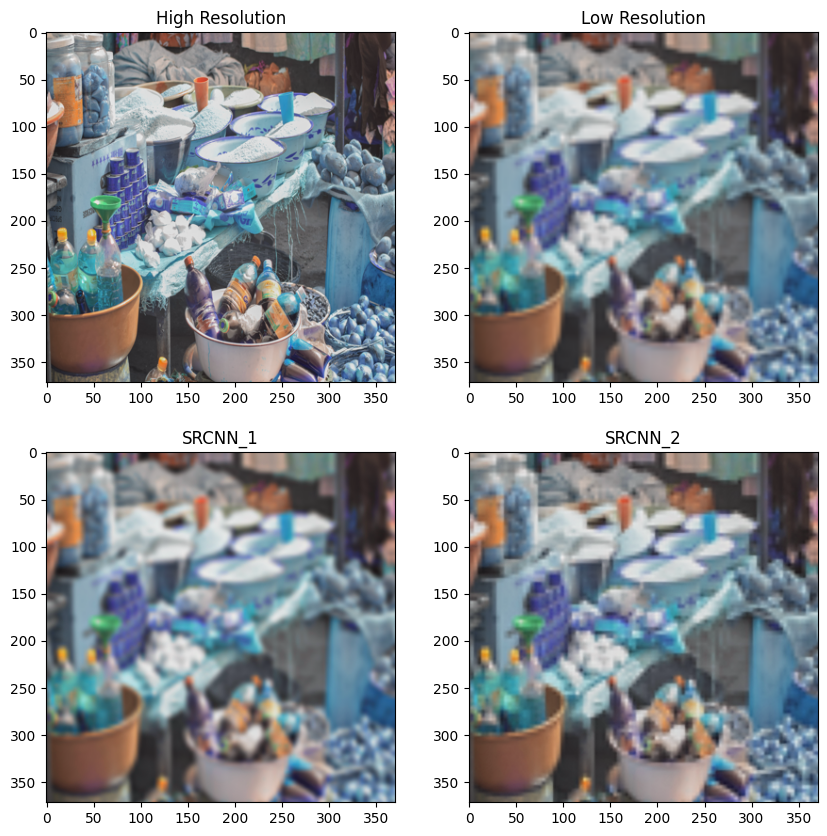

In [57]:
plot_results('/content/Data/LR/70.png', SRCNN_1, SRCNN_2)

1/1 [==============================] - 0s 18ms/step
Native scores:  [30.703640270012922, 55.298879807552964, 0.8894952055030162] 
Scores of SRCNN_1:  [27.769852607227378, 108.66635509955655, 0.8674242511464119] 
Scores of SRCNN_2:  [30.817696879312265, 53.86549720314176, 0.8935158564893643]


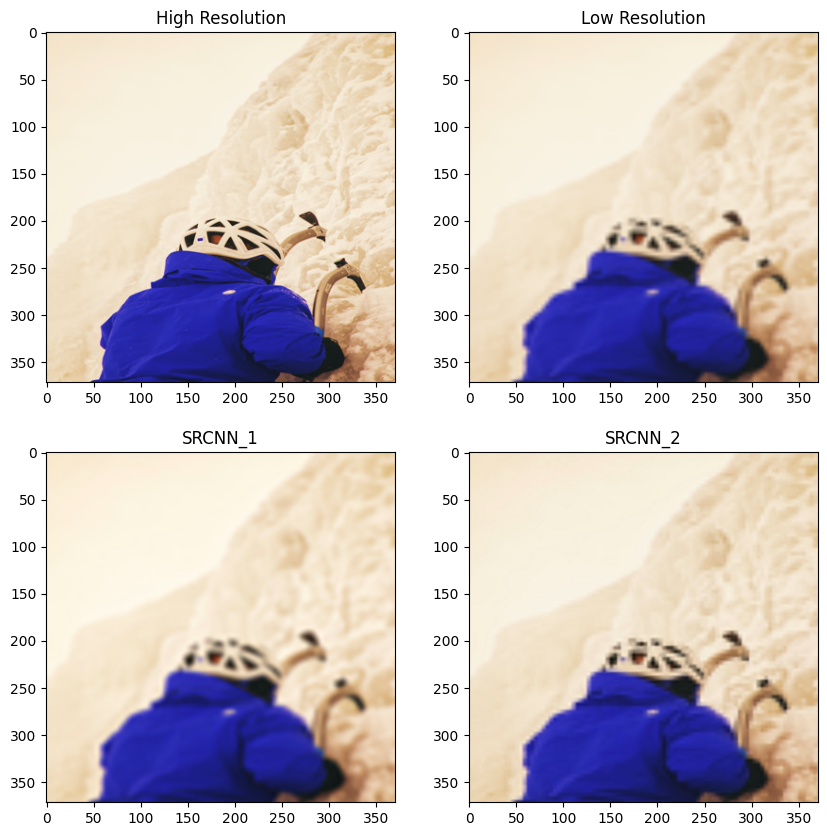

In [58]:
plot_results('/content/Data/LR/43.png', SRCNN_1, SRCNN_2)

1/1 [==============================] - 0s 16ms/step
Native scores:  [24.047583778512404, 256.0483508680405, 0.4755664811555828] 
Scores of SRCNN_1:  [23.960162927153235, 261.2546735066516, 0.427880131085926] 
Scores of SRCNN_2:  [24.1021098367385, 252.85373735617193, 0.5038311925200825]


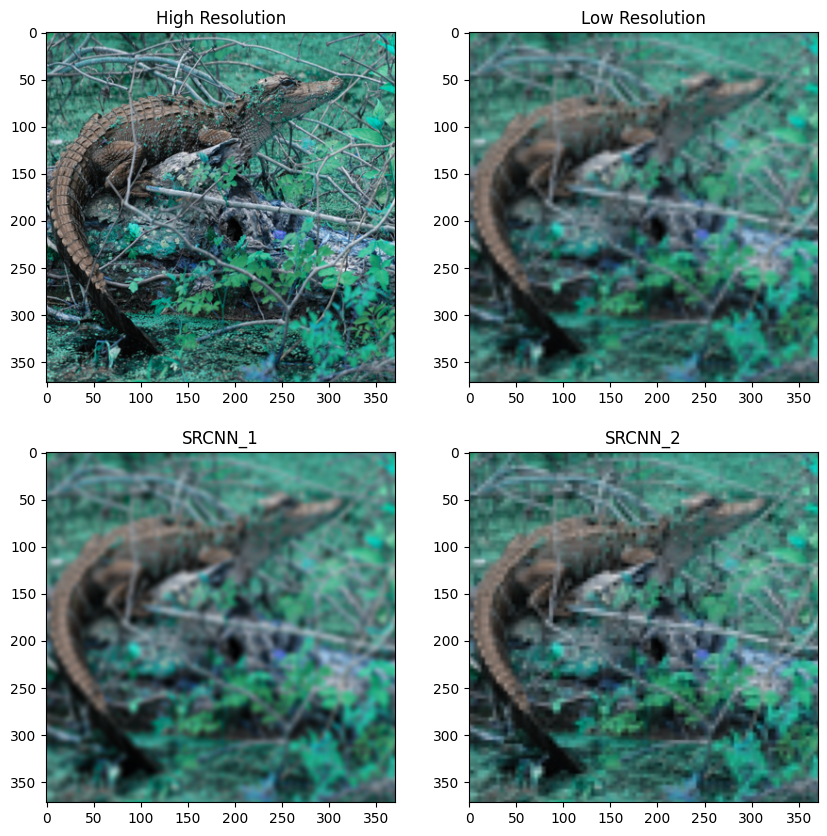

In [59]:
plot_results('/content/Data/LR/69.png', SRCNN_1, SRCNN_2)

1/1 [==============================] - 0s 18ms/step
Native scores:  [26.926219464406092, 131.96489435701244, 0.7861558221353793] 
Scores of SRCNN_1:  [25.92349806787651, 166.23809523809524, 0.7512579171882375] 
Scores of SRCNN_2:  [27.11826043634633, 126.25666608700692, 0.801563765687372]


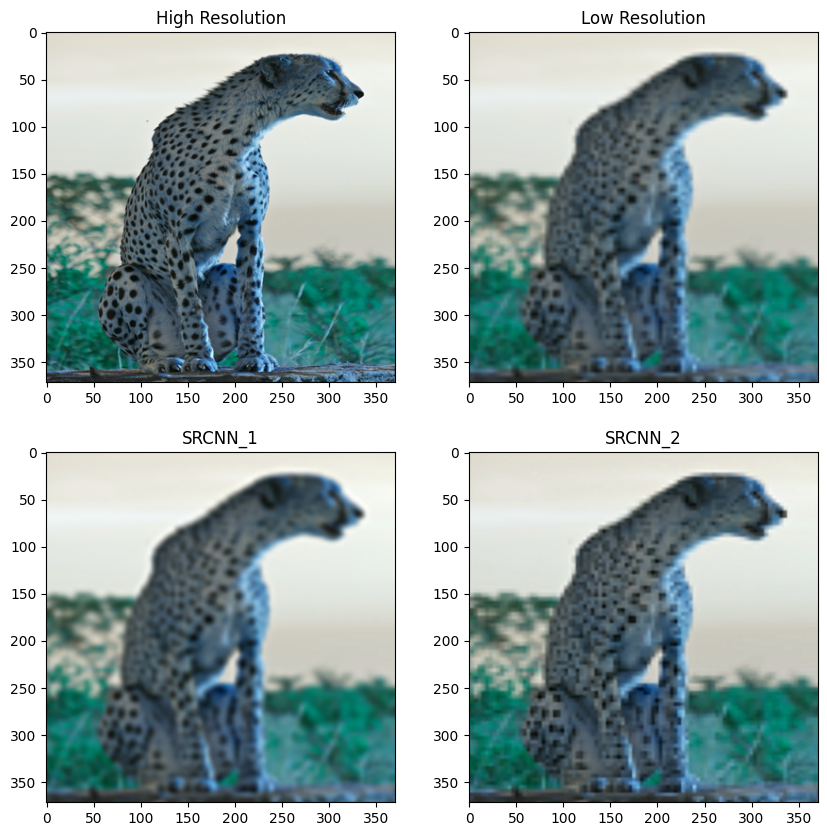

In [60]:
plot_results('/content/Data/LR/62.png', SRCNN_1, SRCNN_2)

##References:


1.   https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution
2.   https://github.com/kunal-visoulia/Image-Restoration-using-SRCNN
3.   https://arxiv.org/abs/1501.00092
4.   https://github.com/MarkPrecursor/SRCNN-keras



